# Trading Interest Rates Swaps

#### by Gustavo Soares

In this notebook you will apply a few things you learned in our Python lecture [FinanceHub's Python lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Python%20Lectures):

* You will use and manipulate different kinds of variables in Python such as text variables, booleans, date variables, floats, dictionaries, lists, list comprehensions, etc.;
* We will also use `Pandas.DataFrame` objects and methods which are very useful in manipulating financial time series;
* You will use if statements and loops, and;
* You will use user defined functions;
* You will use [FinanceHub's Bloomberg tools](https://github.com/Finance-Hub/FinanceHub/tree/master/bloomberg) for fetching data from a Bloomberg terminal. If you are using this notebook within BQNT, you may want to use BQL for getting the data.

## Introduction to Interest Rates Swaps (IRS)

An interest rate swap (IRS) is a type of contract through which two counterparties agree to exchange one stream of interest payments for another, based on a specified principal amount. In most cases, interest rate swaps include the exchange of a fixed interest rate for a floating rate. The *payer* leg of the swap pays periodically (typically every 6 months) interest accrued at a fixed interest rate whcih is mutually agred by the two counterparties at the contract inception. The *receiver* leg of the contract pays periodically (typically every 3 months) interest accrued at a floating interest rate (typically Libor).

Because interest rates are currency specific (so 5% interest in BRL is not the same as in USD), the IRS are also typically currency specific. Because they trade over the counter (OTC), the contract between the two parties can be set according to their desired specifications and can be customized in many different ways and cross-currency swaps are IRS for which the two parties agree to exchange interest payments and/or principal denominated in two different currencies. Here we focus on single-currency IRS and let's look at USD swaps for simplicity.

In USD, there are two common and liquid types of fixed-for-floating IRS:

1. Plain-vanilla semi-annual 30/360 vs. 3M Libor
2. IMM semi-annual vs. 3M Libor

The major difference between these two types of swaps are the expire dates. Plain-vanilla swaps trade at constrant maturity, so the expiration date of the wap will typically be one, two, five, etc. years from the trade date. The IMM swaps on the other hand have fixed expiry with expiration dates following the cycle of international money market futures and IMM futures options which are the third Wednesday of Mar/Jun/Sep/Dec.

### The swaps curve

The swaps *curve* is a chart that depicts the IRS maturity $T$ on the x-axis and the prevailing fixed rate of the IRS, $r_{T}$. Naturally, the swaps *curve* is continously changing as futures prices are constinously changing with market conditions. So, a *curve* is associated with a particular point in time $t$ and we can think of it as a chart of $\{(T,r_{t,T})\}_{T}$ for the different contract maturities $T$. For plain-vanilla IRS we have fixed values ${T=1,...,30$ in x-axis which expresse their maturities in years.

Let's now import [FinanceHub's Bloomberg tools](https://github.com/Finance-Hub/FinanceHub/tree/master/bloomberg) for fetching data from Bloomberg and show the plain-vanilla semi-annual 30/360 vs. 3M Libor curve. Before you do that you need to make sure that the directory where you placed the FinanceHub project is in the python's root directory.

In [1]:
import sys
sys.path
finance_hub_path_name = r'C:\Users\gsoares\Dropbox\FinanceHub' # change this to your path name
if finance_hub_path_name not in sys.path:
    sys.path.append(finance_hub_path_name) # this will append the FinanceHub folder into the python's root directory if not there
sys.path

['',
 'C:\\Users\\gsoares\\Dropbox\\FinanceHub',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\python36.zip',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\DLLs',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\lib',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36',
 'C:\\Users\\gsoares\\AppData\\Roaming\\Python\\Python36\\site-packages',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\lib\\site-packages',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\lib\\site-packages\\twixreader-1.0-py3.6.egg',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\lib\\site-packages\\win32',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\gsoares\\AppData\\Roaming\

If your finance_hub_path_name shows up in the sys.path above, you are all good!

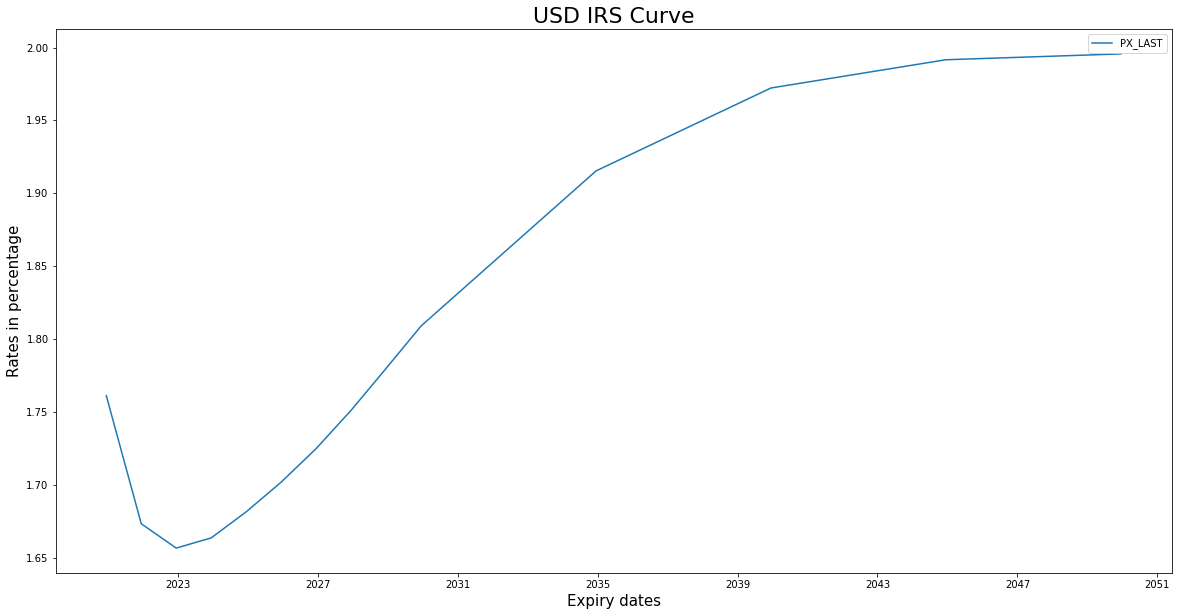

In [11]:
import pandas as pd
from bloomberg import BBG
import matplotlib.pyplot as plt
%matplotlib inline
# this line above is only neeeded when using the matplotlib library in an interactive platform like Jupyter Notebooks

bbg = BBG() # because BBG is a class, we need to create an instance of the BBG class wihtin this notebook, here deonted by b

# list with the Bloomberg tickers for the plain-vanilla swap rates for different liquid tenors
usd_irs_tickers = [
    'USSW1 Curncy',
    'USSW2 Curncy',
    'USSW3 Curncy',
    'USSW4 Curncy',
    'USSW5 Curncy',
    'USSW6 Curncy',
    'USSW7 Curncy',
    'USSW8 Curncy',
    'USSW9 Curncy',
    'USSW10 Curncy',
    'USSW15 Curncy',
    'USSW20 Curncy',
    'USSW25 Curncy',
    'USSW30 Curncy'
]

# download rates and maturity dates
rates_df = bbg.fetch_contract_parameter(usd_irs_tickers, 'PX_LAST')
ytm_df = bbg.fetch_contract_parameter(usd_irs_tickers, 'MATURITY')

# concatenate the two to create a single dataframe
irs_curve = pd.concat([ytm_df,rates_df],axis=1,sort=True).sort_values('MATURITY').set_index('MATURITY')

# plot the curve
irs_curve.plot(figsize=(20,10))
plt.title('USD IRS semi-annual 30/360 vs. 3M Libor curve' ,fontsize=22)
plt.xlabel('Expiry dates',fontsize=15)
plt.ylabel('Rates in percentage',fontsize=15)
plt.show()

## Fixed leg calculation

Let now take one of those swaps, the 10Y IRS, and calculate the fixed interest rate payments. Since these are plain-vanilla semi-annual IRS, then payments are made every six months. We will use [FinanceHub's Calendar tools](https://github.com/Finance-Hub/FinanceHub/tree/master/calendars) for calculating the payment dates. We also use `relativedelta` from the `dateutil` library to add and subtract months from dates.

In [44]:
from calendars import DayCounts
# We initialize the daycount class with 30E/360 ISDA because that is the acrrural rule for 30/360 swaps
# and we use 'us_trading' calendar to find the payment dates
dc = DayCounts('30E/360 ISDA', calendar='us_trading')

notional = 10000000
tenor = 10

fixed_rate = rates_df.loc['USSW%s Curncy' % str(tenor), 'PX_LAST']
expiry_date = ytm_df.loc['USSW%s Curncy' % str(tenor), 'MATURITY']
fixed_leg = pd.Series()
for i in range(2*tenor): #since the swap has semi-annual payments, we will have twice as many payments as the tenor value
    
    # find payment date by subtracting months from the expiry date
    pay_date = expiry_date + relativedelta(months=-i*6)
    previous_pay_date = expiry_date + relativedelta(months=(-i-1)*6)
    
    # note that the dates above may not be a business days
    # so we will use the daycount class modified_following() method to find the next business day
    pay_date = dc.modified_following(pay_date)
    previous_pay_date = dc.modified_following(previous_pay_date)
    
    # calculates the time fraction in years under between now and the last payment date according to the 30E/360 ISDA convention 
    accrual_time = dc.tf(previous_pay_date, pay_date)
    
    interest_amount = (fixed_rate/100)*accrual_time*notional # remember interest rates in the USD are linear!
    principal_amount = notional*(i==0)
    total_amount = principal_amount + interest_amount
    fixed_leg[pay_date] = int(total_amount)

fixed_leg = fixed_leg.sort_index().to_frame('receiver_payments')
fixed_leg

,receiver_payments
2020-06-16,90449
2020-12-16,90449
2021-06-16,90449
2021-12-16,90449
2022-06-16,90449
2022-12-16,90449
2023-06-16,90449
2023-12-18,91454
2024-06-17,89947
2024-12-16,89947


### Floating leg calculation

Let now take the same 10Y IRS and calculate the floating interest rate payments. Since these are plain-vanilla 3M Libor IRS, then payments are made every three months. The floating leg of swap will pay interest accrued by the realized 3M Libor over the payment date and the previous payment date. Note that at inception, this is not known, so the actual floating leg of swap payments are a random variable.

For reasons that go beyond the scope of the notebook here, arbitrage arguments show that at inceptions, the floating leg of swap payments on date $T_{1}$ should be calculated using the forward rate between $T_{0}$ and $T_{1}$, where $T_{0}$ is the last payment date.

The forward interest rate between $T_{0}$ and $T_{1}$, $f_{T_{0},T_{1}}$, is the interest rate that can be locked today for some future period between $T_{0}$ and $T_{1}$. It is the rate at which a party commits to borrow or lend a sum of money at some future date. Forward rates can be computed from a *zero-coupon curve* or *zero curve*.

A zero curve is a special type of interest rate curve that maps interest rates on zero-coupon bonds to different maturities across time. Zero-coupon bonds have a single payment at maturity, so these curves enable you to price arbitrary cash flows, fixed-income instruments, and derivatives. Given a zero curve $\{Z_{T}\}_{T}$ for different maturities $T$, we can compute the forward rate between $T_{0}$ and $T_{1}$ using the formula:

$$
    f_{T_{0},T_{1}} \equiv \frac{(1+Z_{T_{1}})^{T_{1}/(T_{1} - T_{0})}}{(1+Z_{T_{0}})^{T_{0}/(T_{1} - T_{0})}}-1
$$

So, in order to calculate the floating interest rate payments, we need to first obtain the *zero curve*.

#### The zero curve

In finance, *bootstrapping* is a method for constructing a (zero-coupon) fixed-income yield curve from the prices of a set of coupon-bearing products, e.g. bonds and swaps. A bootstrapped curve is one where the prices of the instruments used as an input to the curve, will be an exact output, when these same instruments are valued using this curve. Here, the term structure of spot returns is recovered from the bond yields by solving for them recursively, by forward substitution: this iterative process is called the bootstrap method (not to be confused with the Bootstrap method in Statistics!). The usefulness of bootstrapping is that using only a few carefully selected zero-coupon products, it becomes possible to derive par swap rates (forward and spot) for all maturities given the solved curve. Fortunantly, Bloomberg already bootstraps a zero-coupon curve for us using Eurodollar futures and the IRS semi-annual swaps:

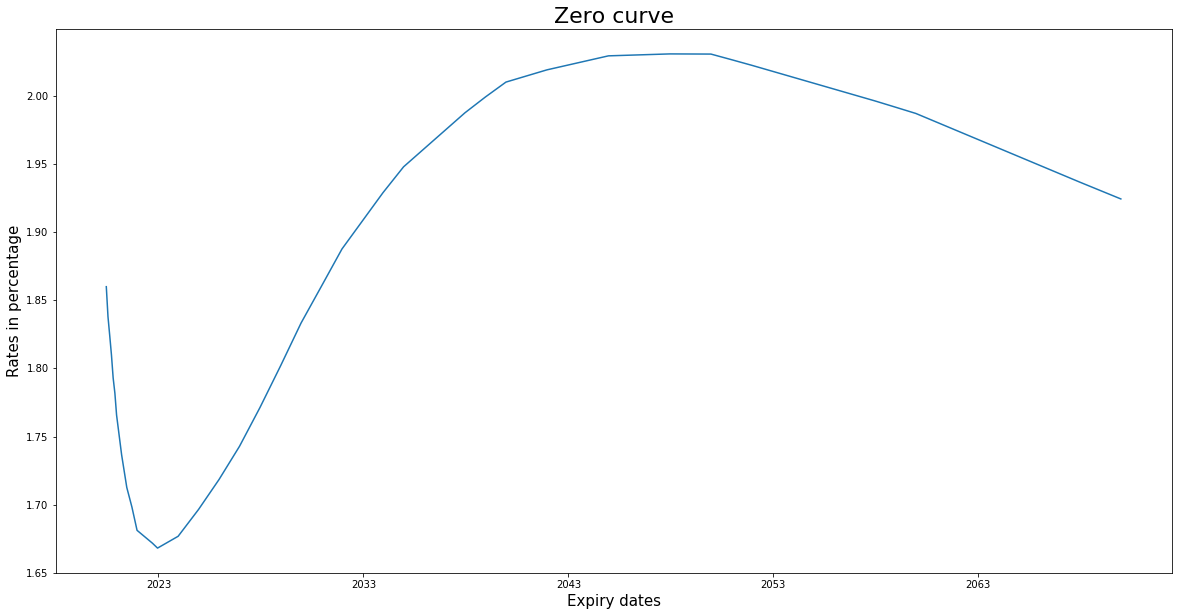

MATURITY
2020-06-16    1.85993
2020-07-16    1.83792
2020-08-17    1.82365
2020-09-16    1.80981
2020-10-16    1.79307
2020-11-16    1.78189
2020-12-16    1.76587
2021-03-16    1.73671
2021-06-16     1.7128
2021-09-16    1.69833
2021-12-16    1.68137
2022-09-16    1.67195
2022-12-16    1.66836
2023-12-18    1.67701
2024-12-16    1.69668
2025-12-16    1.71862
2026-12-16    1.74296
2027-12-16    1.77142
2028-12-18    1.80203
2029-12-17    1.83331
2030-12-16    1.86033
2031-12-16    1.88757
2033-12-16    1.92883
2034-12-18    1.94778
2037-12-16    1.98738
2038-12-16    1.99897
2039-12-16    2.00986
2041-12-16    2.01883
2044-12-16    2.02909
2047-12-16    2.03051
2049-12-16    2.03039
2050-12-16     2.0263
2051-12-18    2.02211
2057-12-17    1.99606
2058-12-16    1.99149
2059-12-16    1.98687
2067-12-16    1.93653
2069-12-16    1.92423
Name: 2019-12-12 00:00:00, dtype: object

In [74]:
# list with the Bloomberg tickers for the zero-coupon curve used in projecting the floating leg
tickers_zero_curve = ['S0023Z 1Y BLC2 Curncy',
                      'S0023Z 3M BLC2 Curncy',
                      'S0023Z 10Y BLC2 Curncy',
                      'S0023Z 1M BLC2 Curncy',
                      'S0023Z 2Y BLC2 Curncy',
                      'S0023Z 6M BLC2 Curncy',
                      'S0023Z 2M BLC2 Curncy',
                      'S0023Z 5Y BLC2 Curncy',
                      'S0023Z 4M BLC2 Curncy',
                      'S0023Z 9M BLC2 Curncy',
                      'S0023Z 3Y BLC2 Curncy',
                      'S0023Z 4Y BLC2 Curncy',
                      'S0023Z 50Y BLC2 Curncy',
                      'S0023Z 12Y BLC2 Curncy',
                      'S0023Z 18M BLC2 Curncy',
                      'S0023Z 7Y BLC2 Curncy',
                      'S0023Z 5M BLC2 Curncy',
                      'S0023Z 1Y BLC Curncy',
                      'S0023Z 6Y BLC2 Curncy',
                      'S0023Z 2W BLC2 Curncy',
                      'S0023Z 11M BLC2 Curncy',
                      'S0023Z 15M BLC2 Curncy',
                      'S0023Z 21M BLC2 Curncy',
                      'S0023Z 15Y BLC2 Curncy',
                      'S0023Z 25Y BLC2 Curncy',
                      'S0023Z 8Y BLC2 Curncy',
                      'S0023Z 10M BLC2 Curncy',
                      'S0023Z 20Y BLC2 Curncy',
                      'S0023Z 33M BLC2 Curncy',
                      'S0023Z 7M BLC2 Curncy',
                      'S0023Z 8M BLC2 Curncy',
                      'S0023Z 11Y BLC2 Curncy',
                      'S0023Z 14Y BLC2 Curncy',
                      'S0023Z 18Y BLC2 Curncy',
                      'S0023Z 19Y BLC2 Curncy',
                      'S0023Z 9Y BLC2 Curncy',
                      'S0023Z 10Y BLC Curncy',
                      'S0023Z 10Y ICPL Curncy',
                      'S0023Z 17M BLC2 Curncy',
                      'S0023Z 1M BLC Curncy',
                      'S0023Z 22Y BLC2 Curncy',
                      'S0023Z 28Y BLC2 Curncy',
                      'S0023Z 30Y BLC2 Curncy',
                      'S0023Z 31Y BLC2 Curncy',
                      'S0023Z 32Y BLC2 Curncy',
                      'S0023Z 38Y BLC2 Curncy',
                      'S0023Z 39Y BLC2 Curncy',
                      'S0023Z 40Y BLC2 Curncy',
                      'S0023Z 42D BLC2 Curncy',
                      'S0023Z 48Y BLC2 Curncy',
                      'S0023Z 6M BLC Curncy']

# download maturity dates
zero_ytm_df = bbg.fetch_contract_parameter(tickers_zero_curve, 'MATURITY')

# for some reason we cannot use bbg.fetch_contract_parameter(tickers_zero_curve, "PX_LAST")
# because Bloomberg API sends back an error message:
# "Attempt to access unavailable sub-element 'PX_LAST' of element 'fieldData'. (0x0006000d)"
# but we can get the zero coupon rates like this
zero_rates_df = bbg.fetch_series(tickers_zero_curve, "PX_LAST",
                          startdate = pd.to_datetime('today'),
                          enddate = pd.to_datetime('today'))


# concatenate the two to create a single dataframe
zero_curve = pd.concat([zero_ytm_df,zero_rates_df.T],axis=1,sort=True).set_index('MATURITY').iloc[:,0].dropna().sort_index()

# plot the curve
zero_curve.plot(figsize=(20,10))
plt.title('Zero curve' ,fontsize=22)
plt.xlabel('Expiry dates',fontsize=15)
plt.ylabel('Rates in percentage',fontsize=15)
plt.show()
zero_curve

#### Calculating forward rates with flat foward interpolation

Now, let's create a function that given a zero coupon curve  $\{Z_{T}\}_{T}$, it computes the the forward rate between $T_{0}$ and $T_{1}$, $f_{T_{0},T_{1}}$, using the formula above. Note that the values $T_{0}$ and $T_{1}$ may not belonw to the set of maturities in $\{Z_{T}\}_{T}$. In that case, we need to find $Z_{T_{0}}$ and $Z_{T_{1}}$ via interpolation. Here, we use the *flat forward* interpolation method. In order to do that, let's import [FinanceHub's FlatFoward class](https://github.com/Finance-Hub/FinanceHub/blob/master/finmath/SwapCurve/SwapCurve.py) for carrying out this interpolation.

In [98]:
from finmath.SwapCurve.SwapCurve import FlatForward   
ff = FlatForward()

def get_fwd_rate(D0,D1,z_curve):
    
    if D1 <= min(pd.to_datetime(z_curve.index)):
        return z_curve.iloc[0]/100
    elif D0 >= max(pd.to_datetime(z_curve.index)):
        return z_curve.iloc[-1]/100
    else:
        ytms = [dc.tf(pd.to_datetime('today'), x) for x in z_curve.index]
        rates = [z_curve[x]/100 for x in z_curve.index]

        T0 = dc.tf(pd.to_datetime('today'), D0)
        T1 = dc.tf(pd.to_datetime('today'), D1)

        Z = ff.interpolate(rates,ytms,[T0,T1],360)

        return ((1+Z[1])**(T1/(T1-T0))) / ((1+Z[0])**(T0/(T1-T0))) - 1

D0 = fixed_leg.index[2]
D1 = fixed_leg.index[4]
fwd_rate = get_fwd_rate(D0,D1,zero_curve)

print('The forward rate in between %s and %s is %s' %(D0.strftime('%Y-%m-%d'),D1.strftime('%Y-%m-%d'),fwd_rate))

The forward rate in between 2021-06-16 and 2022-06-16 is 0.016165634080346436


#### Calculating the floating leg payments

Now we are ready to calcualte the floating leg payments:

In [100]:
float_leg = pd.Series()
for i in range(4*tenor): #since the swap has quarterly payments, we will have four times as many payments as the tenor value
    
    # find payment date by subtracting months from the expiry date
    pay_date = expiry_date + relativedelta(months=-i*3)
    previous_pay_date = expiry_date + relativedelta(months=(-i-1)*3)
    
    # note that the dates above may not be a business days
    # so we will use the daycount class modified_following() method to find the next business day
    pay_date = dc.modified_following(pay_date)
    previous_pay_date = dc.modified_following(previous_pay_date)
    
    # calculates the time fraction in years under between now and the last payment date according to the 30E/360 ISDA convention 
    accrual_time = dc.tf(previous_pay_date, pay_date)
    
    fwd_rate = get_fwd_rate(previous_pay_date,pay_date,zero_curve)
    
    interest_amount = fwd_rate*accrual_time*notional # remember interest rates in the USD are linear!
    principal_amount = notional*(i==0)
    total_amount = principal_amount + interest_amount
    float_leg[pay_date] = int(total_amount)
    
float_leg = float_leg.sort_index().to_frame('payer_payments')
float_leg

,payer_payments
2020-03-16,46498
2020-06-16,46498
2020-09-16,42685
2020-12-16,40805
2021-03-16,40471
2021-06-16,39806
2021-09-16,40272
2021-12-16,39049
2022-03-16,41167
2022-06-16,41167


### Pricing

Now let's concatenate the cash flows of the fixed/payer leg with the projected cash flows of the floating/receiver leg:

In [105]:
cash_flows = pd.concat([fixed_leg,-float_leg],join='outer',axis=1,sort=True).fillna(0)
cash_flows['net_cash_flow'] = cash_flows.iloc[:,0] + cash_flows.iloc[:,1]
cash_flows

,receiver_payments,payer_payments,net_cash_flow
2020-03-16,0.0,-46498,-46498.0
2020-06-16,90449.0,-46498,43951.0
2020-09-16,0.0,-42685,-42685.0
2020-12-16,90449.0,-40805,49644.0
2021-03-16,0.0,-40471,-40471.0
2021-06-16,90449.0,-39806,50643.0
2021-09-16,0.0,-40272,-40272.0
2021-12-16,90449.0,-39049,51400.0
2022-03-16,0.0,-41167,-41167.0
2022-06-16,90449.0,-41167,49282.0


In order to price this swap we now need to discount the projected net cash flows with some sort of discount factor. Typically, for IRS we use the OIS Curve to calculate the discount factors:

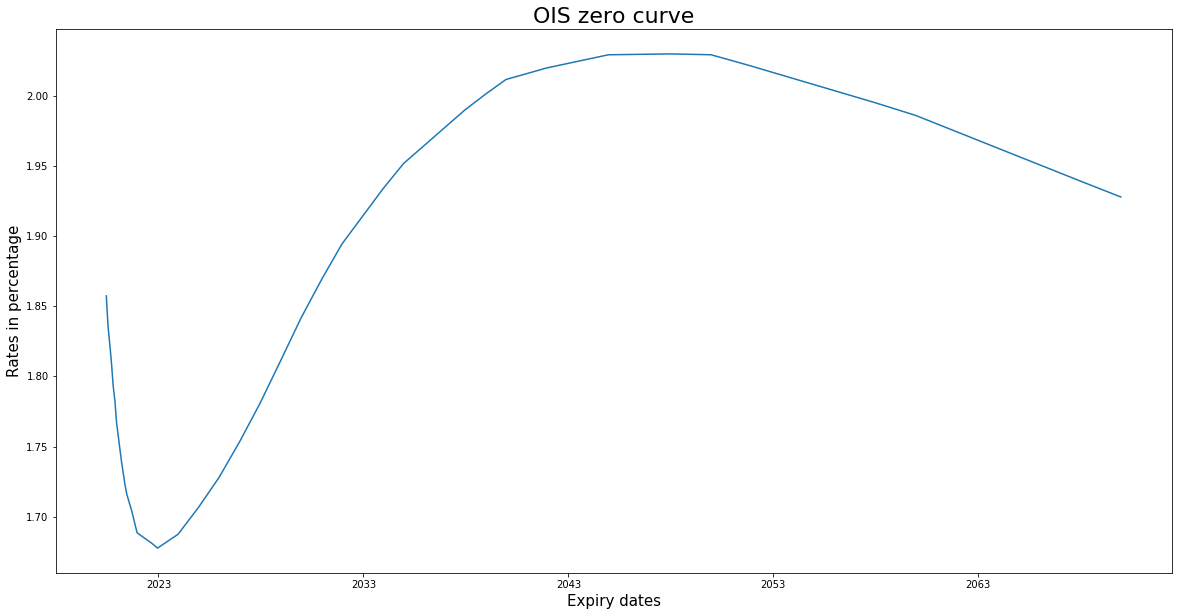

MATURITY
2020-06-16    1.85738
2020-07-16    1.83621
2020-08-17    1.82283
2020-09-16    1.80981
2020-10-16    1.79349
2020-11-16    1.78275
2020-12-16    1.76714
2021-03-16    1.73873
2021-05-17    1.72245
2021-06-16    1.71619
2021-09-16    1.70371
2021-12-16    1.68871
2022-09-16    1.68085
2022-12-16    1.67778
2023-12-18    1.68766
2024-12-16    1.70683
2025-12-16    1.72807
2026-12-16     1.7534
2027-12-16    1.78083
2028-12-18    1.81125
2029-12-17    1.84168
2030-12-16    1.86892
2031-12-16    1.89435
2033-12-16    1.93364
2034-12-18    1.95166
2037-12-16    1.98983
2038-12-16    2.00099
2039-12-16    2.01146
2041-12-16    2.01974
2044-12-16    2.02907
2047-12-16    2.02969
2049-12-16     2.0291
2050-12-16    2.02504
2051-12-18    2.02087
2057-12-17    1.99498
2058-12-16    1.99043
2059-12-16    1.98583
2067-12-16    1.93929
2069-12-16     1.9278
Name: 2019-12-12 00:00:00, dtype: object

In [120]:
# list with the Bloomberg tickers for the zero-coupon curve used in projecting the floating leg
ois_zero_curve = [x.replace('S0','SD0') for x in tickers_zero_curve]


# for some reason we cannot use bbg.fetch_contract_parameter(tickers_zero_curve, "PX_LAST")
# because Bloomberg API sends back an error message:
# "Attempt to access unavailable sub-element 'PX_LAST' of element 'fieldData'. (0x0006000d)"
# but we can get the zero coupon rates like this
ois_rates_df = bbg.fetch_series(ois_zero_curve, "PX_LAST",
                          startdate = pd.to_datetime('today'),
                          enddate = pd.to_datetime('today'))

# download maturity dates
ois_ytm_df = bbg.fetch_contract_parameter(ois_zero_curve, 'MATURITY')


# concatenate the two to create a single dataframe
ois_curve = pd.concat([ois_ytm_df,ois_rates_df.T],axis=1,sort=True).set_index('MATURITY').iloc[:,0].dropna().sort_index()

# # plot the curve
ois_curve.plot(figsize=(20,10))
plt.title('OIS zero curve' ,fontsize=22)
plt.xlabel('Expiry dates',fontsize=15)
plt.ylabel('Rates in percentage',fontsize=15)
plt.show()
ois_curve

Now, let's create a function that given the OIS curve  $\{r_{T}\}_{T}$, it computes the discount factor for a given date $T_{0}$ and use it to calculate the present value of the net cash flow:

In [154]:
def get_discount_factor(d,discount_curve):
    t = dc.tf(pd.to_datetime('today'), d)
    
    if d <= min(pd.to_datetime(discount_curve.index)):
        ref_rate =  discount_curve.iloc[0]/100
    elif d >= max(pd.to_datetime(discount_curve.index)):
        ref_rate = discount_curve.iloc[-1]/100
    else:
        ytms = [dc.tf(pd.to_datetime('today'), x) for x in discount_curve.index]
        rates = [discount_curve[x]/100 for x in discount_curve.index]        
        Z = ff.interpolate(rates,ytms,[t],360)
        ref_rate = Z[0]
        
    return (1+ref_rate*t)**-1
    
cash_flows['discount_factor'] = [get_discount_factor(pd.to_datetime(x),ois_curve) for x in cash_flows.index]
cash_flows['present_value'] = (cash_flows['net_cash_flow']*cash_flows['discount_factor']).astype(int)
cash_flows

,receiver_payments,payer_payments,net_cash_flow,discount_factor,present_value
2020-03-16,0.0,-46498,-46498.0,0.995174,-46273
2020-06-16,90449.0,-46498,43951.0,0.990596,43537
2020-09-16,0.0,-42685,-42685.0,0.986412,-42105
2020-12-16,90449.0,-40805,49644.0,0.982446,48772
2021-03-16,0.0,-40471,-40471.0,0.978543,-39602
2021-06-16,90449.0,-39806,50643.0,0.974722,49362
2021-09-16,0.0,-40272,-40272.0,0.970870,-39098
2021-12-16,90449.0,-39049,51400.0,0.967154,49711
2022-03-16,0.0,-41167,-41167.0,0.963288,-39655
2022-06-16,90449.0,-41167,49282.0,0.959453,47283


Now, to price the swap, we just add all the values in the present_value columns:

In [158]:
print('The price of the swap is %s as percentage of the notional' % (cash_flows.iloc[-1].sum()/notional))

The price of the swap is 0.010533584429239719 as percentage of the notional


### Exercises

#### Beginners

The PV01 of a swap is the present value of a swap with .01% coupon and the DV01 of a swap is the change in value of the swap for a .01% parallel shift in the swap curve. Calcualte the PV01 and DV01 for the swap we priced in this notebook.

#### Beginners/Intermediate

Create a function that takes as input the tenor of the swap and its notional and returns as output the cash_flows dataframe above.

#### Intermediate

Create a function that takes as input the tenor of the swap and its notional and returns as output the cash_flows dataframe as well as its PV01 and DV01.

#### Advanced

Starting with the swaps of shortest maturity, recursively, find the discount_curve that makes the present value of the net cash flows of the payer and receiver leg add up to zero.

#### Advanced

Calculate the return of getting into the payer leg of swap on one date $T_{0}$ and closing the positions some time afterwards in a date $T_{1}$.

#### Advanced/Master

Create a function that takes as input the tenor of the swap and its notional and returns as output a dataframe containing the cash_flows dataframe above but with the discount_factor columns calculated as in the exercise above, so the present value of the net cash flows of the payer and receiver leg add up to zero.

#### For Jedi masters

Create a function that takes as input the tenor of the swap and its notional and returns as output a dataframe containing the cash_flows dataframe above but with the discount_factor columns calculated as in the exercise above, so the present value of the net cash flows of the payer and receiver leg add up to zero. Also, create a function that takes as input the tenor of the swap and its notional and returns as output this zero net present cash_flows dataframe and returns its PV01 and DV01.